# Distribution B - Maximum Likelihood

In [101]:
import DistBTrunc as dbt
import DistExampB as db

import cvxpy as cp

from math import ceil, floor, log, sqrt
from matplotlib import pyplot as plot
from numpy import sinc
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from sympy import Symbol, lambdify

from LocMath import Bisect
from LocUtil import Grid1, LogGrid1, MinMax, MinIndex, SetSeed, UnZip
from Map import LogRatio
from Sinc import InterpZ

In [102]:
nSamp = 100

givenSeed = None
seedDig = 3

nPlot = 101
figSize = (9, 6.5)

dist = db.ExampB()

In [103]:
seed = SetSeed(givenSeed, seedDig)
if givenSeed is None:
	print(f'seed = {seed}')

samp = sorted(tuple(dist.Sample() for _ in range(nSamp)))
quant = tuple((k + 0.5) / nSamp for k in range(nSamp))

seed = 989


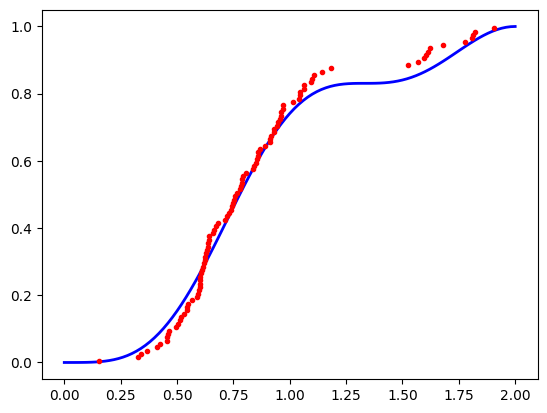

In [104]:
plot.plot(samp,quant, '.', c='red')

xGrid = Grid1(0,2,nPlot)
cdfX = tuple(dist.Cdf(x) for x in xGrid)
plot.plot(xGrid, cdfX, c="blue", lw=2, zorder=-1)

## Map to Z

In [105]:
xSym = Symbol('x')
zSym = Symbol('z')

map_ = LogRatio(xSym, zSym, (0, 2))

In [106]:
map_.forSym

log(x/(2 - x))

In [107]:
sampZ = tuple(map_.Forward(x) for x in samp)

## Log Likelihood

In [108]:
zMin,zMax = MinMax(sampZ)
zMin,zMax

(-2.492203357474241, 3.0090765128095214)

In [109]:
nSinc = 11
sincZ = Grid1(zMin,zMax, nSinc)
h = (zMax - zMin) / (nSinc - 1)
h

0.5501279870283762

In [110]:
sincVal = cp.Variable(nSinc)
sincVal

Variable((11,), var781046)

In [111]:
logLikeP = lambda z: cp.log(sum(sv * sinc((z - sz) / h) for (sz,sv) in zip(sincZ,sincVal)))
obj = cp.Maximize(sum(logLikeP(z) for z in sampZ))

In [112]:
xSym = map_.xSym
zSym = map_.zSym

phiPrimeZSym = map_.DerivSym(1).subs(xSym, map_.invSym).simplify()
phiPrimeZSym

2*cosh(z/2)**2

In [113]:
phiPrimZ = lambdify(zSym, phiPrimeZSym)

In [114]:
constEach = list(0 <= sv for sv in sincVal)
constTotal = h * sum(sv / phiPrimZ(sz) for (sz,sv) in zip(sincZ, sincVal)) == 1
const = constEach + [constTotal]

In [115]:
prob = cp.Problem(obj,const)

In [116]:
prob.solve()

-11.936826497997757

In [117]:
sincV = list(sincVal.value)

#### View on the X-axis

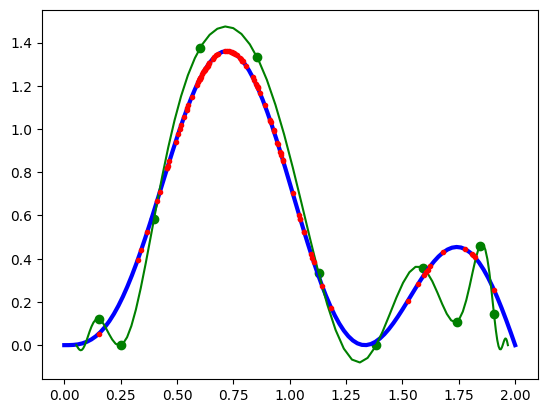

In [118]:
sincX = tuple(map_.Inverse(z) for z in sincZ)
plot.plot(sincX, sincVal.value, 'o', c='green')

xGrid = Grid1(0,2, nPlot)
pdf = tuple(dist.Pdf(x) for x in xGrid)
plot.plot(xGrid,pdf, c='blue', linewidth=3)

zGrid = Grid1(zMin - 2*h, zMax + 2*h, nPlot)
xGrid = tuple(map_.Inverse(z) for z in zGrid)
interp = InterpZ(sincZ,sincV, zGrid)
plot.plot(xGrid,interp, c='green')

sampPdf = tuple(dist.Pdf(x) for x in samp)
plot.plot(samp,sampPdf, '.', c='red')

#### View on the Z-axis

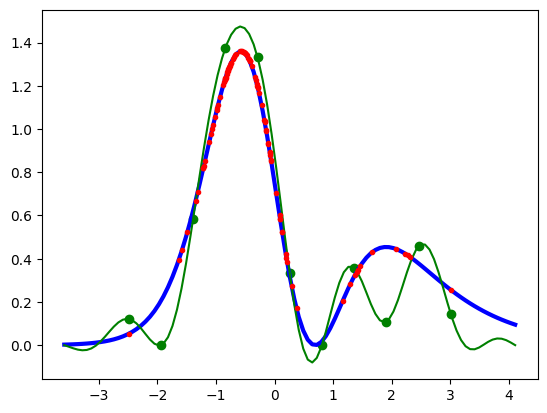

In [119]:
sincX = tuple(map_.Inverse(z) for z in sincZ)
plot.plot(sincZ, sincVal.value, 'o', c='green')

zGrid = Grid1(zMin - 2*h, zMax + 2*h, nPlot)
pdf = tuple(dist.Pdf(map_.Inverse(z)) for z in zGrid)
plot.plot(zGrid,pdf, c='blue', linewidth=3)

interp = InterpZ(sincZ,sincV, zGrid)
plot.plot(zGrid,interp, c='green')

sampPdf = tuple(dist.Pdf(x) for x in samp)
plot.plot(sampZ,sampPdf, '.', c='red')

## Try to vary H

In [120]:
zMin,zMax

(-2.492203357474241, 3.0090765128095214)

In [121]:
lev = LogGrid1(quant[0], 0.1, nPlot)

In [122]:
Quant = interp1d(sampZ, quant)

In [123]:
zMinLev = tuple(Bisect(Quant, l, (zMin, 0)) for l in lev)

In [124]:
zMaxLev = tuple(Bisect(Quant, 1 - l, (0,zMax)) for l in lev)

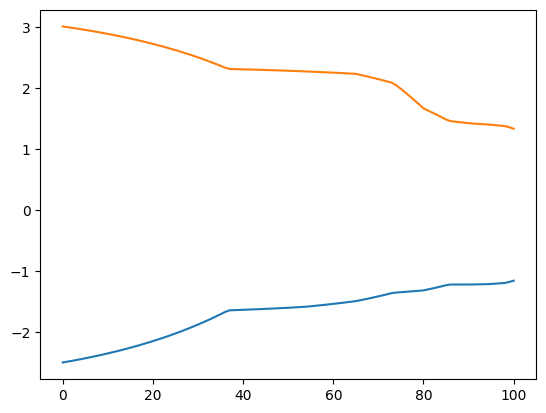

In [125]:
plot.plot(zMinLev)
plot.plot(zMaxLev)

In [126]:
result = []
for k in range(len(lev)):
	sincZ = Grid1(zMinLev[k],zMaxLev[k], nSinc)
	h = (zMaxLev[k] - zMinLev[k]) / (nSinc - 1)

	logLikeP = lambda z: cp.log(sum(sv * sinc((z - sz) / h) for (sz, sv) in zip(sincZ, sincVal)))
	obj = cp.Maximize(sum(logLikeP(z) for z in sampZ))

	constEach = list(0 <= sv for sv in sincVal)
	constTotal = h * sum(sv / phiPrimZ(sz) for (sz, sv) in zip(sincZ, sincVal)) == 1
	const = constEach + [constTotal]
	
	prob = cp.Problem(obj, const)
	result.append((prob.solve(), tuple(sincVal.value)))

F:\Users\Kenne.DESKTOP-BT6VROU\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [127]:
len(result)

101

In [128]:
result[0]

(-11.936826519653858,
 (0.1211462895003797,
  5.81662546121653e-10,
  0.5837444333916771,
  1.374741000189956,
  1.3328409734343545,
  0.33230950674366605,
  -1.1735594337365065e-09,
  0.3570357138094317,
  0.10903244795853453,
  0.45716962047725973,
  0.14461852461154712))

Text(0, 0.5, 'Log of Likelihood')

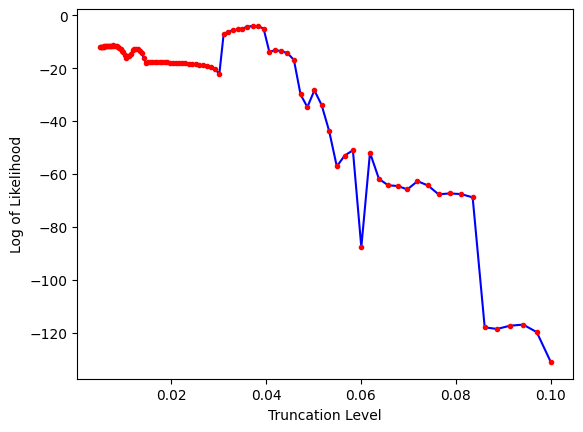

In [129]:
logLike = tuple(ll for (ll,_) in result)

plot.plot(lev[:len(result)], logLike, c='blue')
plot.plot(lev[:len(result)], logLike, '.', c='red')

plot.xlabel('Truncation Level')
plot.ylabel('Log of Likelihood')

#### Visualize (this part is broken)

In [130]:
zMin = zMinLev[0]
zMax = zMaxLev[0]
zMin,zMax

(-2.492203357473957, 3.0090765128091794)

In [131]:
sincV = result[0][1]

In [132]:
sincZ = Grid1(zMinLev[k],zMaxLev[k], nSinc)
h = (zMaxLev[k] - zMinLev[k]) / (nSinc - 1)

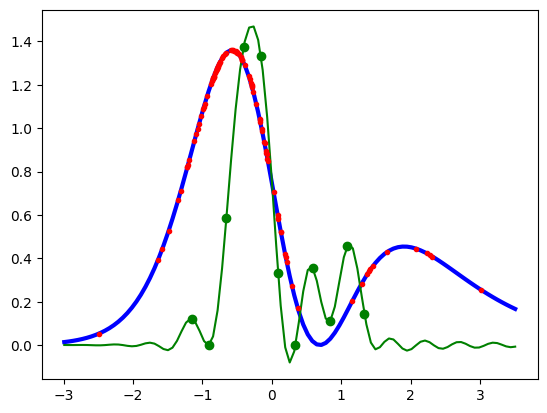

In [133]:
sincX = tuple(map_.Inverse(z) for z in sincZ)
plot.plot(sincZ, sincV, 'o', c='green')

zGrid = Grid1(zMin - 2*h, zMax + 2*h, nPlot)
pdf = tuple(dist.Pdf(map_.Inverse(z)) for z in zGrid)
plot.plot(zGrid,pdf, c='blue', linewidth=3)

interp = InterpZ(sincZ,sincV, zGrid)
plot.plot(zGrid,interp, c='green')

sampPdf = tuple(dist.Pdf(x) for x in samp)
plot.plot(sampZ,sampPdf, '.', c='red')